In [667]:
import prestodb

conn = prestodb.dbapi.connect(
       host='watsonxdata',
       port=8443,
       user='ibmlhadmin',
       catalog='hive_data',
       schema='ontime',
       http_scheme='https',
       auth=prestodb.auth.BasicAuthentication("ibmlhadmin", "password")
)
conn._http_session.verify = '/certs/lh-ssl-ts.crt'
airport_cur = conn.cursor()

In [668]:
airport_cur.execute("SELECT dayofmonth, dot_id_reporting_airline, flight_number_reporting_airline,originairportid, destairportid, crsdeptime,deptime, depdelay,crsarrtime, arrtime, arrdelay,crselapsedtime, distance,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay FROM hive_data.ontime.ontime LIMIT 100000")
ontime_data = airport_cur.fetchall()

In [669]:
column_description = airport_cur.description
find_ontime = {column[0]: index for index, column in enumerate(column_description)}


In [674]:
ontime_data[0][find_ontime["arrtime"]]

2057

In [675]:
import pandas as pd
df = pd.DataFrame(ontime_data)
#cols = ['DayOfMonth','OriginAirportID', 'DestAirportID', 'Distance', 'CRSDepTime', 'CRSElapsedTime', 'DepTime', 'CRSArrTime', 'ArrTime']
#df.columns = cols

In [676]:
cr_arrdelay = df.corrwith(df.iloc[:, find_ontime["arrdelay"]])
cr_arrtime = df.corrwith(df.iloc[:, find_ontime["arrtime"]])

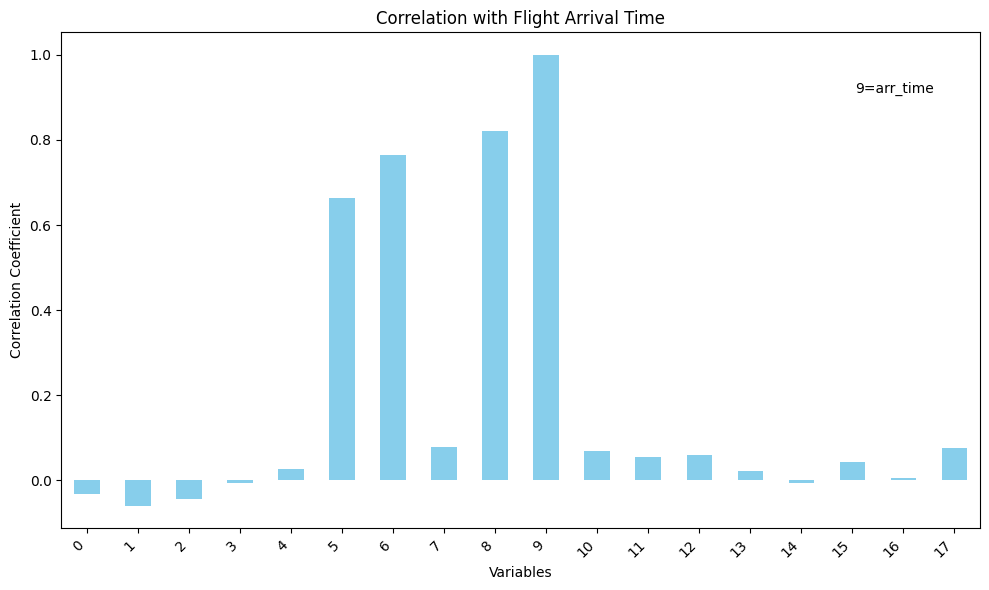

In [677]:
import matplotlib.pyplot as plt
# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
cr_arrtime.plot(kind='bar', color='skyblue')
plt.title('Correlation with Flight Arrival Time')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.text(0.95, 0.9, '9=arr_time',
         fontsize=10, ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

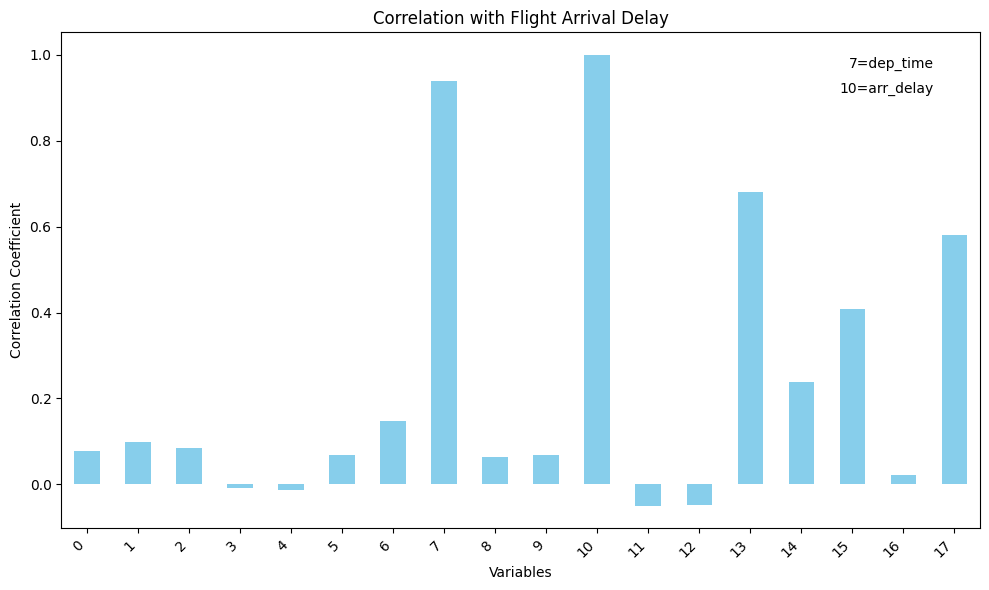

In [678]:
# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
cr_arrdelay.plot(kind='bar', color='skyblue')
plt.title('Correlation with Flight Arrival Delay')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.text(0.95, 0.95, '7=dep_time',
         fontsize=10, ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.95, 0.9, '10=arr_delay',
         fontsize=10, ha='right', va='top', transform=plt.gca().transAxes)


plt.show()

#Comments: astounding linear correlation between arrival delay and departure delay.

In [679]:
x=[]
y=[]
for row in ontime_data:
    x.append(row[find_ontime["arrdelay"]])
    y.append(row[find_ontime["crselapsedtime"]])

len(x), len(y)

(100000, 100000)

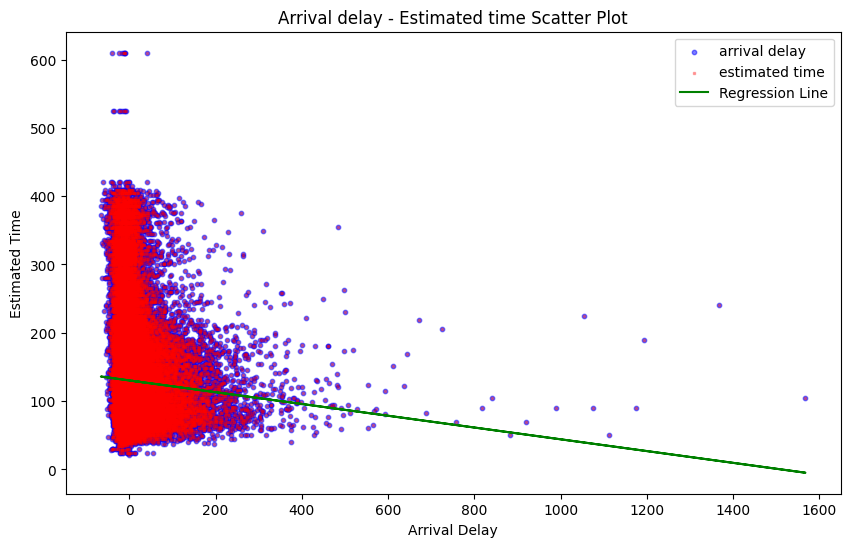

In [682]:
slope, intercept = np.polyfit(x, y, 1)

plt.figure(figsize=(10, 6))  

# Create scatter plot with custom colors and marker shapes
plt.scatter(x, y, color = "blue", label='arrival delay', alpha=0.5, marker='o', s=10)
plt.scatter(x, y, color = "red", label='estimated time', alpha=0.3, marker='s', s=2)

plt.plot(x, slope * np.array(x) + intercept, color='green', label='Regression Line')

# Add labels and title
plt.xlabel('Arrival Delay')
plt.ylabel('Estimated Time')
plt.title('Arrival delay - Estimated time Scatter Plot')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [683]:
airport_cur.execute("SELECT dayofmonth, dot_id_reporting_airline, flight_number_reporting_airline,originairportid, destairportid, crsdeptime,deptime, depdelay,crsarrtime, arrtime, arrdelay,crselapsedtime, actualelapsedtime, distance,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay FROM hive_data.ontime.ontime LIMIT 100000")
ontime_data = airport_cur.fetchall()
column_description = airport_cur.description
find_ontime = {column[0]: index for index, column in enumerate(column_description)}

In [684]:
import numpy as np
from scipy.optimize import curve_fit


# Define a non-linear function
def nonlinear_func(x, a, b):
    return a * np.exp(b * x)  # Example of a non-linear function (exponential)

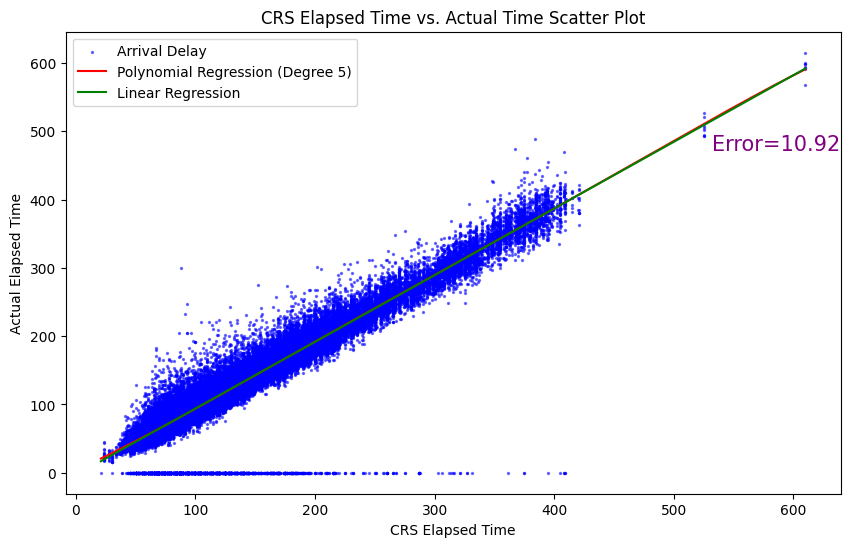

In [685]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Sample data
x = []
y = []
for row in ontime_data:
    x.append(row[find_ontime["crselapsedtime"]])
    y.append(row[find_ontime["actualelapsedtime"]])

# Convert lists to NumPy arrays
x = np.array(x)
y = np.array(y)

# Define a non-linear function
def polynomial_func(x, *coefficients):
    return np.polyval(coefficients, x)

# Perform polynomial regression (change the degree as needed)
degree = 5  # Example degree
coefficients = np.polyfit(x, y, degree)

# Generate x values for the fitted curve within the range of the original data
x_fit = np.linspace(min(x), max(x), 1000)  # Generate 100 points for smoother curve

# Generate y values for the polynomial regression curve
y_fit_poly = polynomial_func(x_fit, *coefficients)

# Interpolate the polynomial regression curve at the original x values
y_fit_poly_interpolated = np.interp(x, x_fit, y_fit_poly)

# Perform linear regression for comparison
slope, intercept = np.polyfit(x, y, 1)

# Calculate the predicted values for linear regression using the same x values as polynomial regression
y_fit_linear = slope * x_fit + intercept


errors = y_fit_poly_interpolated - y

# Compute the standard deviation of the errors
std_deviation = np.std(errors)
std_deviation = "{:.2f}".format(std_deviation)


# Calculate the mean error between the interpolated polynomial regression curve and the original y values
error = np.abs(y_fit_poly_interpolated - y).mean()

# Limit the accuracy of the error value to two decimal places
error = "{:.2f}".format(error)

plt.figure(figsize=(10, 6))  

# Create scatter plot for original data
plt.scatter(x, y, color="blue", label='Arrival Delay', alpha=0.5, marker='o', s=2)

# Plot the polynomial regression curve
plt.plot(x_fit, y_fit_poly, color='red', label='Polynomial Regression (Degree {})'.format(degree))
plt.plot(x_fit, y_fit_linear, color='green', label='Linear Regression')

# Add labels and title
plt.xlabel('CRS Elapsed Time')
plt.ylabel('Actual Elapsed Time')
plt.title('CRS Elapsed Time vs. Actual Time Scatter Plot')

# Display the error as text
plt.text(max(x)-78, max(y)-120, 'Error=' + str(error), fontsize=15, color='purple', verticalalignment='top')

# Add legend
plt.legend()

# Display the plot
plt.show()


# means that new_expected_time = expected_time + w1*dep_delay + w2*carrier_delay + w3*weather_delay + w4*nas_delay + w5*security_delay + w6*late_aircraft_delay

In [686]:
# Lets test this only for Chicago

In [687]:
#Lets update the data
airport_cur.execute("SELECT dest, dayofmonth, dot_id_reporting_airline, flight_number_reporting_airline,originairportid, destairportid, crsdeptime,deptime, depdelay,crsarrtime, arrtime, arrdelay,crselapsedtime, distance,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay FROM hive_data.ontime.ontime LIMIT 100000")
column_description = airport_cur.description
find_ontime = {column[0]: index for index, column in enumerate(column_description)}
chicago_data = airport_cur.fetchall()

In [688]:
chicago_data[0]

['MSP',
 27,
 20363,
 3341,
 11298,
 13487,
 1821,
 1823,
 2,
 2049,
 2057,
 8,
 148,
 852,
 0,
 0,
 0,
 0,
 0]

In [689]:
chicago_data = [row for row in chicago_data if row[0] == "ORD"]

In [690]:
chicago_data[0]

['ORD',
 1,
 20363,
 3338,
 12478,
 13930,
 1540,
 1546,
 6,
 1748,
 1753,
 5,
 188,
 740,
 0,
 0,
 0,
 0,
 0]

In [439]:
chicago_data = [[row[i] for i in range(len(row)) if i != 0] for row in chicago_data]

In [440]:
# chicago_data[2][find_ontime["arrdelay"]]

In [441]:
df = pd.DataFrame(chicago_data)

In [442]:
cr_arrdelay_chicago = df.corrwith(df.iloc[:, find_ontime["arrdelay"]])
cr_arrtime_chicago = df.corrwith(df.iloc[:, find_ontime["arrtime"]])

/usr/local/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [443]:
cr_arrdelay_chicago

0    -0.046963
1    -0.483224
2    -0.576383
3     0.225071
4          NaN
5    -0.116035
6    -0.081839
7    -0.002276
8     0.103823
9     0.094620
10   -0.019746
11    1.000000
12    0.968580
13    0.019806
14    0.028947
15   -0.026892
16         NaN
17   -0.052955
dtype: float64

In [444]:
light_red = plt.get_cmap('Reds')(0.6)  # Adjust the value (between 0 and 1) to control the intensity of red

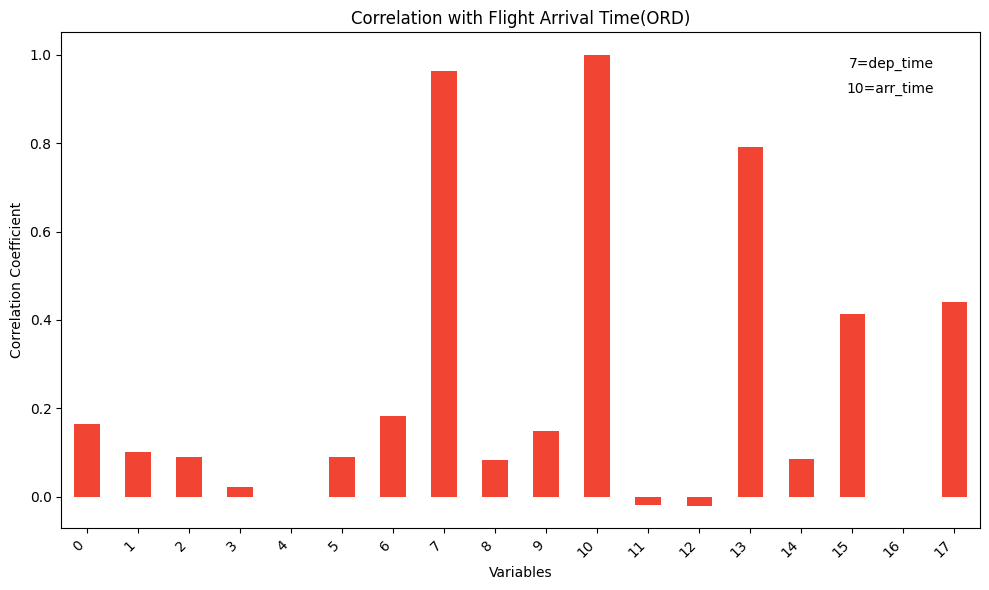

In [649]:
import matplotlib.pyplot as plt
# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
cr_arrtime_chicago.plot(kind='bar', color=light_red)
plt.title('Correlation with Flight Arrival Time(ORD)')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.text(0.95, 0.95, '7=dep_time',
         fontsize=10, ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.95, 0.9, '10=arr_time',
         fontsize=10, ha='right', va='top', transform=plt.gca().transAxes)

plt.show()

#again in here, big correlation between arrival time and departure time.

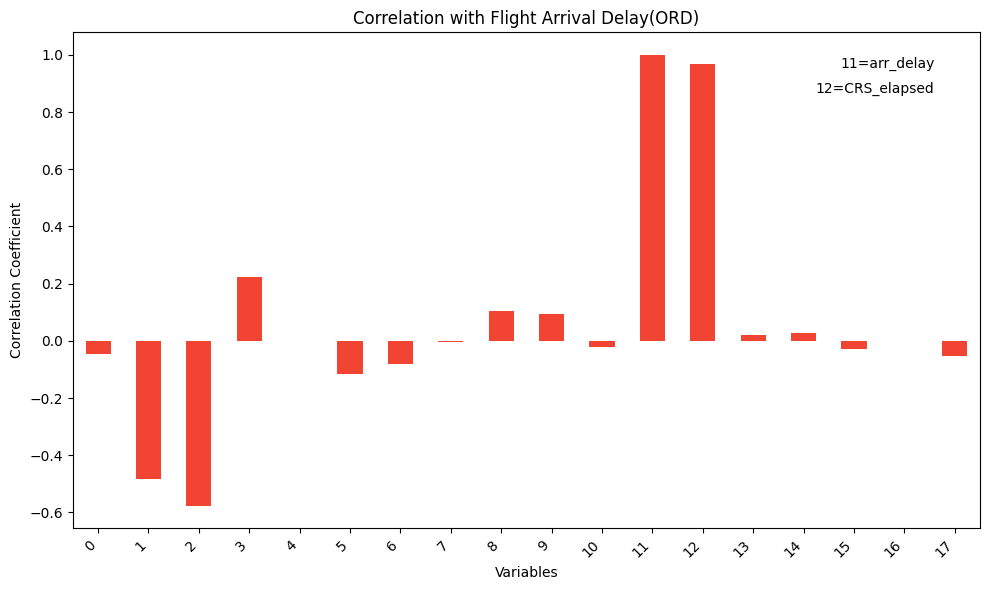

In [651]:
# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
cr_arrdelay_chicago.plot(kind='bar', color=light_red)
plt.title('Correlation with Flight Arrival Delay(ORD)')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.text(0.95, 0.95, '11=arr_delay',
         fontsize=10, ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.95, 0.9, '12=CRS_elapsed',
         fontsize=10, ha='right', va='top', transform=plt.gca().transAxes)

plt.show()


In [447]:
# Woah! Correlation between arrival delay and the scheduled trip duration? What is happening here?

In [448]:
x=[]
y=[]
for row in ontime_data:
    x.append(row[find_ontime["arrdelay"]])
    y.append(row[find_ontime["crselapsedtime"]])

len(x), len(y)

(100000, 100000)

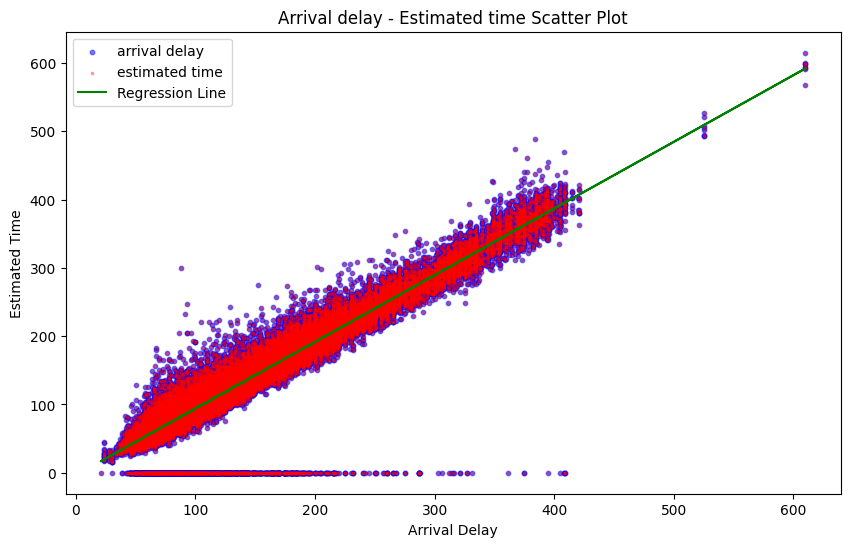

In [695]:
slope, intercept = np.polyfit(x, y, 1)

plt.figure(figsize=(10, 6))  

# Create scatter plot with custom colors and marker shapes
plt.scatter(x, y, color = "blue", label='arrival delay', alpha=0.5, marker='o', s=10)
plt.scatter(x, y, color = "red", label='estimated time', alpha=0.3, marker='s', s=2)

plt.plot(x, slope * np.array(x) + intercept, color='green', label='Regression Line')

# Add labels and title
plt.xlabel('Arrival Delay')
plt.ylabel('Estimated Time')
plt.title('Arrival delay - Estimated time Scatter Plot')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [693]:
#Lets load up the taxi data!
import prestodb

conn = prestodb.dbapi.connect(
       host='watsonxdata',
       port=8443,
       user='ibmlhadmin',
       catalog='hive_data',
       schema='taxi',
       http_scheme='https',
       auth=prestodb.auth.BasicAuthentication("ibmlhadmin", "password")
)
conn._http_session.verify = '/certs/lh-ssl-ts.crt'
taxi_cursor = conn.cursor()

In [694]:
taxi_cursor.execute("SELECT dropoff_latitude, dropoff_longitude, extras, fare, pickup_latitude, pickup_longitude, tips, tolls, trip_end_timestamp, trip_miles, trip_seconds, trip_start_timestamp, trip_total FROM hive_data.taxi.taxirides LIMIT 100000")
taxi_data = taxi_cursor.fetchall()

In [452]:
column_description = taxi_cursor.description
find_taxi = {column[0]: index for index, column in enumerate(column_description)}

In [453]:
from datetime import datetime

def parse_timestamp(timestamp_str):
    # Parse the timestamp string into a datetime object
    datetime_obj = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S.%f')
    
    # Get the timestamp in seconds
    timestamp = datetime_obj.timestamp()
    
    return timestamp

In [454]:
#trip end times are useless.
len(taxi_data) == len([row for row in taxi_data if taxi_data[0][find_taxi["trip_end_timestamp"] == '2013-01-01 00:00:00.000']])


True

In [455]:
len(taxi_data)

42326

In [456]:
#Lets parse the timestamps
for i in range(0, len(taxi_data)):
    taxi_data[i][find_taxi["trip_end_timestamp"]] = parse_timestamp(taxi_data[i][find_taxi["trip_end_timestamp"]])
    taxi_data[i][find_taxi["trip_start_timestamp"]] = parse_timestamp(taxi_data[i][find_taxi["trip_start_timestamp"]])

In [457]:
df = pd.DataFrame(taxi_data)
cr = df.corrwith(df.iloc[:, find_taxi["trip_total"]])

In [458]:
cr

0     0.008350
1    -0.027800
2     0.187583
3     0.982128
4     0.006357
5    -0.020577
6     0.025360
7     0.699948
8    -0.002920
9     0.016624
10    0.030396
11   -0.004289
12    1.000000
dtype: float64

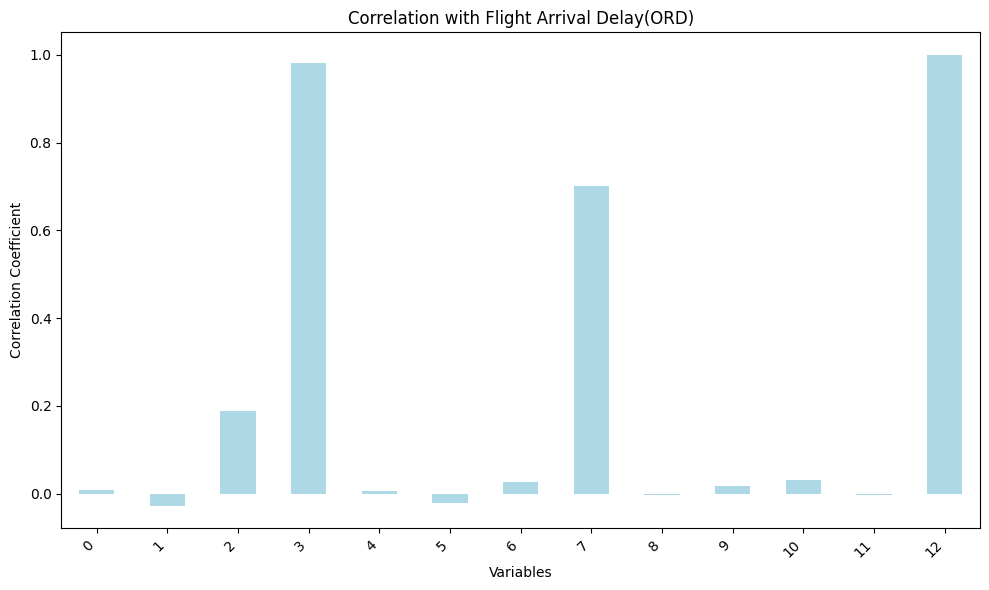

In [459]:
# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
cr.plot(kind='bar', color="lightblue")
plt.title('Correlation with Flight Arrival Delay(ORD)')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [460]:
#no visible correlation after mutliple changes

In [461]:
import math

def get_distance(lat1, lon1, lat2, lon2):
    if lat1 is None or lon1 is None or lat2 is None or lon2 is None:
        # print("sdoifjsd")
        return float('inf')  # Return infinity if any coordinate is missing
        
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Calculate the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula to calculate distance
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

In [462]:
airport_lat = 41.978611
airport_long = -87.904724
get_distance(41.97907082, -87.90303966, airport_lat, airport_long)*1000

148.32130555297636

In [463]:
radius = 1

In [464]:
taxi_data_from_airport = []
taxi_data_to_airport = []
counter = 0
for row in taxi_data:
    lat = row[find_taxi["pickup_latitude"]]
    long = row[find_taxi["pickup_longitude"]]
    if (lat == None or long == None):
        counter+=1
        continue
    if get_distance(lat, long, airport_lat, airport_long) <= radius:
        taxi_data_from_airport.append(row)

for row in taxi_data:
    lat = row[find_taxi["dropoff_latitude"]]
    long = row[find_taxi["dropoff_longitude"]]
    if (lat == None or long == None):
        counter+=1
        continue
    if get_distance(lat, long, airport_lat, airport_long) <= radius:
        taxi_data_to_airport.append(row)
counter

4738

In [465]:
len(taxi_data_from_airport)


753

In [466]:
len(taxi_data_to_airport)


749

In [467]:
#around 1500 trips from-to airport.

In [468]:
miles = 0
time = 0
from_coordinates = []
counter = 0
for row in taxi_data_from_airport:
    current_miles = row[find_taxi["trip_miles"]]
    if (current_miles == 0):
        counter+=1
        continue
    miles += row[find_taxi["trip_miles"]]
    time += row[find_taxi["trip_seconds"]]
    
    # Extract latitude and longitude
    pickup_latitude = row[find_taxi["pickup_latitude"]]
    pickup_longitude = row[find_taxi["pickup_longitude"]]

    if (pickup_latitude == None or pickup_longitude == None):
        counter+=1
        continue 
    
    from_coordinates.append([pickup_latitude, pickup_longitude])

miles /= len(taxi_data_from_airport)
time /= len(taxi_data_from_airport)
time /= 60

In [469]:
miles, time, counter

(11.722735723771594, 16.136786188579016, 229)

In [470]:
# unfortunate 229 0 mile samples

In [471]:
miles = 0
time = 0
to_coordinates = []
counter = 0
for row in taxi_data_to_airport:
    current_miles = row[find_taxi["trip_miles"]]
    if (current_miles == 0):
        continue
        
    miles += row[find_taxi["trip_miles"]]
    time += row[find_taxi["trip_seconds"]]
    
    # Extract latitude and longitude
    pickup_latitude = row[find_taxi["dropoff_latitude"]]
    pickup_longitude = row[find_taxi["dropoff_longitude"]]

    if (pickup_latitude == None or pickup_longitude == None):
        counter+=1
        continue
    
    # Append coordinates to from_coordinates
    to_coordinates.append([pickup_latitude, pickup_longitude])

miles /= len(taxi_data_to_airport)
time /= len(taxi_data_to_airport)
time /= 60

In [472]:
miles, time, counter

(13.530881174899873, 15.751668891855807, 0)

In [473]:
#We see almost symmetrical data, both in trips count and miles/time.

In [474]:
from_coordinates = np.array(from_coordinates)
to_coordinates = np.array(to_coordinates)

In [475]:
from_coordinates[0], from_coordinates[10]

(array([ 41.97907082, -87.90303966]), array([ 41.98026432, -87.9136246 ]))

In [ ]:
import datetime
import matplotlib.pyplot as plt

sub="SELECT arrtime FROM hive_data.ontime.ontime WHERE dest='ORD' LIMIT 200"
airport_cur.execute(sub)
arrival_times = [row[0] for row in airport_cur.fetchall()]

hourly_arrivals = {}
for hour in arrival_times:
    hourly_arrivals[hour] = hourly_arrivals.get(hour, 0) + 1

plt.figure(figsize=(12, 6))
plt.bar(hourly_arrivals.values(), hourly_arrivals.values(), color='skyblue')
plt.xlabel('Time of the Day')
plt.ylabel('Number of Arrivals')
plt.title('Number of Flights Arriving at Different Times of the Day')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()